In [67]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns
import requests

figure_path = src.figures_path / "genehancer"
os.makedirs(figure_path, exist_ok=True)
chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']

cleanup()

In [ ]:
output_folder = src.external_data_path / 'HG19_geneHancers'
os.makedirs(output_folder, exist_ok=True)

session_id = '745646873_QvoKrgdaECD1RaNBmMQdjNLReCHc'
url = 'http://genome-euro.ucsc.edu/cgi-bin/hgTables?hgsid={}'.format(session_id)    
session = requests.Session()

params = {
    'hgsid': session_id,
    'jsh_pageVertPos': '0',
    'clade': 'mammal',
    'org': 'Human',
    'db': 'hg19',
    'hgta_group': 'regulation',
    'hgta_track': 'geneHancer',
    'hgta_table': 'geneHancerInteractionsDoubleElite',
    'hgta_regionType': 'range',
    'position': '',
    'hgta_outputType': 'primaryTable',
    'boolshad.sendToGalaxy': '0',
    'boolshad.sendToGreat': '0',
    'boolshad.sendToGenomeSpace': '0',
    'hgta_outFileName': '',
    'hgta_compressType': 'none',
    'hgta_doTopSubmit': 'get output'
}

for chrom in chroms:
    print(chrom)
    params['position'] = chrom
    response = session.post(url, data=params)
    with open(output_folder / (chrom + ".txt"), 'w') as f:
        f.write(response.content.decode("utf-8"))

In [12]:
path = src.external_data_path / 'HG19_geneHancers'

genehancers = []

for f in src.progress(os.listdir(path)):
    df = pd.read_csv(path / f, sep="\t")
    df.rename(columns={'#chrom': 'chr', 'chromStart': 'start', 'chromEnd': 'end'}, inplace=True)
    genehancers.append(df)
    
genehancers = pd.concat(genehancers, axis=0).sort_values(src.coords).reset_index(drop=True)

genehancers['length'] = genehancers.end - genehancers.start
genehancers['gh_uid'] = genehancers.index

In [63]:
gaps = pd.read_csv(src.external_data_path / "hg19_gaps.txt", sep="\t")
gaps.columns = ['chr', 'start', 'end', 'gap_type']
gaps = gaps.sort_values(src.coords)
gaps.head()

,chr,start,end,gap_type
1,chr1,0,10000,telomere
0,chr1,121535434,124535434,centromere
2,chr1,249240621,249250621,telomere
35,chr10,0,10000,telomere
33,chr10,39254935,42254935,centromere


In [70]:
all_interTADs = pd.read_csv(src.interim_data_path / "all_interTADs_by_celltype.tsv", sep='\t')
all_interTADs = BedTool.from_dataframe(all_interTADs).subtract(BedTool.from_dataframe(gaps)).to_dataframe(names=all_interTADs.columns)
all_interTADs = all_interTADs[all_interTADs.chr.isin(chroms[:-1])].sort_values(src.coords)
all_interTADs.head()

,chr,start,end,tad_number,cell_type,tad_uid
0,chr1,10000,1612500,0,Mon,Mon_0000
1,chr1,10000,1646875,0,nB,nB_0000
2,chr1,10000,1847500,0,Ery,Ery_0000
3,chr1,10000,2112500,0,Mac0,Mac0_0000
4,chr1,10000,2350000,0,nCD8,nCD8_0000


In [75]:
cell_type = 'Mon'

cell_interTADs = all_interTADs[all_interTADs.cell_type == cell_type].sort_values(src.coords)

In [13]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


In [85]:
consensus_boundaries

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4
5,chr1,2608125,2608125,nB_0002_end,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,5
6,chr1,2697500,2697500,Mac0_0001_start,Mac0,1,1,0,0,1,0,0,0,0,1,3.223947e-10,6
7,chr1,2725000,2725000,"MK_0000_start,nCD8_0000_end","MK,nCD8",2,2,0,1,0,0,0,0,1,1,3.223947e-10,7
8,chr1,2762500,2762500,nCD8_0001_start,nCD8,1,1,0,0,0,0,0,0,1,1,3.223947e-10,8
9,chr1,3355000,3357500,"MK_0000_end,Mac0_0001_end","MK,Mac0",2,2,0,1,1,0,0,0,0,2501,8.063091e-07,9


In [14]:
consensus_boundaries_centers = pd.DataFrame({
    'chr': consensus_boundaries.chr, 
    'start': ((consensus_boundaries.start + consensus_boundaries.end) / 2).astype(int),
    'end': ((consensus_boundaries.start + consensus_boundaries.end) / 2).astype(int),
    'n_cell_types': consensus_boundaries.n_cell_types
})
consensus_boundaries_centers = consensus_boundaries_centers.sort_values(src.coords).reset_index(drop=True)
consensus_boundaries_centers.head()

,chr,start,end,n_cell_types
0,chr1,1612500,1612500,1
1,chr1,1646875,1646875,1
2,chr1,1845000,1845000,3
3,chr1,2112500,2112500,2
4,chr1,2346250,2346250,4


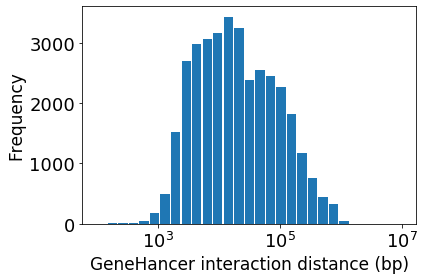

In [76]:
sel_genehancers = genehancers[(genehancers.chr.isin(consensus_boundaries_centers.chr.unique())) & 
                              (genehancers.geneAssociationMethods.str.contains("eQTL") & ~genehancers.geneAssociationMethods.str.contains("C-HiC"))].sort_values(src.coords)

plt.hist(sel_genehancers.length, bins=np.logspace(2, 7, 30), rwidth=0.9)
plt.xscale("log")
plt.xlabel("GeneHancer interaction distance (bp)")
plt.ylabel("Frequency")
plt.show()

In [77]:
gh_with_bounds = BedTool.from_dataframe(sel_genehancers).map(BedTool.from_dataframe(cell_interTADs), c=5, o='count', null=0, F=1)\
                        .to_dataframe(names=sel_genehancers.columns.tolist() + ['n_cell_types'])
gh_with_bounds.head()

,chr,start,end,name,score,value,geneAssociationMethods,color,geneHancerChrom,geneHancerStart,...,geneHancerIdentifier,geneHancerStrand,geneChrom,geneStart,geneEnd,geneName,geneStrand,length,gh_uid,n_cell_types
0,chr1,317718,764181,ENSG00000237094/GH01J000826,16,35.59,"eQTLs,TF_co-expression","119,172,48",chr1,761579,...,GH01J000826,.,chr1,317718,317719,ENSG00000237094,+,446463,0,0
1,chr1,317718,1178914,ENSG00000237094/GH01J001235,13,28.53,"eQTLs,TF_co-expression","119,172,48",chr1,1170966,...,GH01J001235,.,chr1,317718,317719,ENSG00000237094,+,861196,1,0
2,chr1,659929,780357,ENSG00000230021/GH01J000843,2,2.04,"eQTLs,Distance","162,20,47",chr1,778965,...,GH01J000843,.,chr1,659929,659930,ENSG00000230021,-,120428,2,0
3,chr1,752037,762987,LINC01128/GH01J000816,9,18.25,"eQTLs,Distance","0,114,189",chr1,752037,...,GH01J000816,.,chr1,762986,762987,LINC01128,+,10950,3,0
4,chr1,761579,764181,LINC01128/GH01J000826,12,26.64,"eQTLs,Distance","0,114,189",chr1,761579,...,GH01J000826,.,chr1,762986,762987,LINC01128,+,2602,4,0


In [79]:
gh_with_bounds[gh_with_bounds.n_cell_types > 0 ].shape[0] / gh_with_bounds.shape[0]

0.03052064631956912

In [41]:
shuffle_boundaries = BedTool.from_dataframe(consensus_boundaries).shuffle(chrom=True, genome='hg19').to_dataframe(names=consensus_boundaries.columns)
shuffle_boundaries = shuffle_boundaries.sort_values(src.coords)
shuffle_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
1115,chr1,224438,224438,"nCD8_0291_start,nCD4_0283_start","nCD4,nCD8",2,2,0,0,0,0,0,1,1,1,3.223947e-10,1115
441,chr1,299323,299323,nB_0110_end,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,441
884,chr1,576400,576400,nCD8_0235_start,nCD8,1,1,0,0,0,0,0,0,1,1,3.223947e-10,884
353,chr1,580419,580419,Mac0_0110_start,Mac0,1,1,0,0,1,0,0,0,0,1,3.223947e-10,353
445,chr1,639890,662390,"nB_0112_start,nCD8_0123_start,Mon_0105_start,E...","nB,Mon,Ery,nCD8",4,4,1,0,0,1,1,0,1,22501,7.254203e-06,445


In [80]:
shuffle_genehancers = BedTool.from_dataframe(sel_genehancers).shuffle(chrom=True, genome='hg19').to_dataframe(names=sel_genehancers.columns)
shuffle_genehancers = shuffle_genehancers.sort_values(src.coords)
shuffle_genehancers.head()

,chr,start,end,name,score,value,geneAssociationMethods,color,geneHancerChrom,geneHancerStart,geneHancerEnd,geneHancerIdentifier,geneHancerStrand,geneChrom,geneStart,geneEnd,geneName,geneStrand,length,gh_uid
563,chr1,48623,65228,USP48/GH01J021767,15,33.23,"eQTLs,Distance","162,20,47",chr1,22093494,22095777,GH01J021767,.,chr1,22110098,22110099,USP48,-,16605,945
1311,chr1,61541,71963,LEXM/GH01J054813,4,5.33,"eQTLs,Distance","217,83,25",chr1,55279252,55282156,GH01J054813,.,chr1,55271734,55271735,LEXM,+,10422,2574
1590,chr1,128345,145314,LRRC8D/GH01J089836,9,17.83,"eQTLs,Distance","77,190,238",chr1,90301624,90303540,GH01J089836,.,chr1,90286571,90286572,LRRC8D,+,16969,3166
1453,chr1,247713,249814,LRRC7/GH01J069566,481,1181.78,"eQTLs,Distance","77,190,238",chr1,70032259,70034360,GH01J069566,.,chr1,70034079,70034080,LRRC7,+,2101,2912
206,chr1,291235,702489,RERE/GH01J008406,12,25.51,"eQTLs,Distance","126,47,142",chr1,8466448,8473883,GH01J008406,.,chr1,8877701,8877702,RERE,-,411254,331


In [81]:
sh_gh_with_bounds = BedTool.from_dataframe(shuffle_genehancers).map(BedTool.from_dataframe(cell_interTADs), c=5, o='count', null=0, F=1)\
                        .to_dataframe(names=shuffle_genehancers.columns.tolist() + ['n_cell_types'])
sh_gh_with_bounds.head()

,chr,start,end,name,score,value,geneAssociationMethods,color,geneHancerChrom,geneHancerStart,...,geneHancerIdentifier,geneHancerStrand,geneChrom,geneStart,geneEnd,geneName,geneStrand,length,gh_uid,n_cell_types
0,chr1,48623,65228,USP48/GH01J021767,15,33.23,"eQTLs,Distance","162,20,47",chr1,22093494,...,GH01J021767,.,chr1,22110098,22110099,USP48,-,16605,945,0
1,chr1,61541,71963,LEXM/GH01J054813,4,5.33,"eQTLs,Distance","217,83,25",chr1,55279252,...,GH01J054813,.,chr1,55271734,55271735,LEXM,+,10422,2574,0
2,chr1,128345,145314,LRRC8D/GH01J089836,9,17.83,"eQTLs,Distance","77,190,238",chr1,90301624,...,GH01J089836,.,chr1,90286571,90286572,LRRC8D,+,16969,3166,0
3,chr1,247713,249814,LRRC7/GH01J069566,481,1181.78,"eQTLs,Distance","77,190,238",chr1,70032259,...,GH01J069566,.,chr1,70034079,70034080,LRRC7,+,2101,2912,0
4,chr1,291235,702489,RERE/GH01J008406,12,25.51,"eQTLs,Distance","126,47,142",chr1,8466448,...,GH01J008406,.,chr1,8877701,8877702,RERE,-,411254,331,0


In [83]:
sh_gh_with_bounds[sh_gh_with_bounds.n_cell_types > 0].shape[0] / sh_gh_with_bounds.shape[0]

0.02459320053574991

In [ ]:
sel_genehancers = genehancers[(genehancers.length > 1e3) & (genehancers.length < 1e4)]
genehancers_order = sel_genehancers.sort_values("length", ascending=False)['gh_uid'].tolist()
print(sel_genehancers.shape)
print(sel_genehancers.length.min(), sel_genehancers.length.max())
sel_genehancers.head()

In [ ]:
extended = int(1e4 / 2)
window_size = 100

centered_gh = sel_genehancers.copy()
centers = ((centered_gh.start + centered_gh.end)/2).astype(int)
centered_gh['start'] = centers
centered_gh['end'] = centers

centered_gh = BedTool.from_dataframe(centered_gh).slop(b=extended, genome='hg19').to_dataframe(names=centered_gh.columns)
centered_gh.head()

In [ ]:
centered_gh = centered_gh[centered_gh.end - centered_gh.start == extended*2]
windows = src.windowing_by_size(centered_gh[src.coords + ['gh_uid']], window_size=window_size)

In [ ]:
aggregations = {'n_cell_types': 'max'}


windows_with_bound = src.coverage_by_window(windows.sort_values(src.coords), consensus_boundaries_centers.sort_values(src.coords), aggregations)
windows_with_bound = windows_with_bound.merge(centered_gh.drop(src.coords, axis=1), on='gh_uid')
windows_with_bound.head()

In [ ]:
gh_vs_windows = windows_with_bound.pivot_table(index='gh_uid', columns='w_num', values='n_cell_types')

In [ ]:
X = gh_vs_windows.loc[genehancers_order].fillna(0).values

# min_cons = 2

# X[X < min_cons] = 0
# X[X >= min_cons] = 1

In [ ]:
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
ax = ax.matshow(X[:400], aspect='auto',cmap='Greys', interpolation='none')
fig.colorbar(ax)
# plt.yticks([])
# plt.xticks([0, int(X.shape[1]/2), X.shape[1] - 1], ['-4Mb', 'GRB center', "+4Mb"])
# plt.title("Conserved boundaries ($s \geq 2$)\non GRBs")
plt.show()

In [ ]:
X.shape